# **PROJECT TITLE: Yelp Ratings**

In [40]:
import json

import matplotlib.pyplot as plt
# Visualizing missingness
import missingno as msno
import numpy as np
# Import packages
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


## **1. INTRODUCTION**

## **2. ABOUT THE DATA**

In [2]:
# Read the data
df = pd.read_csv("data/MSBA Exit_Yelp.csv")

# Preview the data
df.head()

,attributes,business_id,categories,city,hours,is_open,latitude,longitude,postal_code,review_count,state,stars
0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",922049,"Home Organization, Interior Design, Profession...",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",1,45.551736,-122.552248,97220,11,OR,5.0
1,"{'WiFi': ""u'free'"", 'RestaurantsGoodForGroups'...",492976,"Burgers, Restaurants",Portland,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",1,45.519562,-122.675040,97204,790,OR,4.0
2,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",125987,"Home Services, Tree Services, Landscaping",Austin,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",1,30.296603,-97.970185,78738,6,TX,4.0
3,{'ByAppointmentOnly': 'True'},445542,"Chiropractors, Massage Therapy, Health & Medical",Portland,NaN,0,45.520668,-122.672014,97204,15,OR,5.0
4,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",225939,"Apartments, Real Estate, Home Services",Orlando,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",0,28.520020,-81.457009,32811,7,FL,4.5


In [3]:
# Shape of the dataset
df.shape

(120437, 12)

In [4]:
# Columns inspection
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120437 entries, 0 to 120436
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   attributes    109193 non-null  object 
 1   business_id   120437 non-null  int64  
 2   categories    120351 non-null  object 
 3   city          120437 non-null  object 
 4   hours         99879 non-null   object 
 5   is_open       120437 non-null  int64  
 6   latitude      120437 non-null  float64
 7   longitude     120437 non-null  float64
 8   postal_code   120355 non-null  object 
 9   review_count  120437 non-null  int64  
 10  state         120437 non-null  object 
 11  stars         120437 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 11.0+ MB


## **3. DATA PREPARATION FOR EXPLORATORY DATA ANALYSIS**

This section focus on preparing the data for visualization and exploratory data analysis. Note that we are not dropping any missing values in this section but rather creating additional columns that we will help us create the visualization we want to explore.

#### 3.1. The Hour Column

Create additional columns for the original Hour column. The first column tell us on which days these businesses are closed, the second one shows whether they are closed on Weekends, and the last one tells us how many operating hour in a week.

In [3]:
# Function to evaluate closing status based on hours
def evaluate_closing_status(hours):
    if pd.isnull(hours):
        return "unknown"

    try:
        hours_dict = json.loads(hours.replace("'", '"'))
        closed_days = [day for day, time in hours_dict.items() if time == '0:0-0:0']
        
        if 'Sunday' in closed_days and len(closed_days) == 1:
            return "closed on sunday"
        elif 'Saturday' in closed_days and len(closed_days) == 1:
            return "closed on saturday"
        elif 'Saturday' in closed_days and 'Sunday' in closed_days:
            return "closed on week-ends"
        else:
            week_days_closed = [day for day in closed_days if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']]
            if week_days_closed:
                return f"closed on {len(week_days_closed)} week day(s)"
            return "open all week"
    except:
        return "unknown"

# Apply the function to the hours column
df['closing_status'] = df['hours'].apply(evaluate_closing_status)


In [4]:
# Display the resulting dataframe
df[['business_id', 'hours', 'closing_status']].head()

,business_id,hours,closing_status
0,922049,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",closed on 1 week day(s)
1,492976,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",open all week
2,125987,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",open all week
3,445542,NaN,unknown
4,225939,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",open all week


In [5]:
# Function to calculate total hours and check weekend hours
def process_hours(hours_data):
    if pd.isna(hours_data):
        # Handle NaN values by returning default values
        return 0, False

    # Convert string to dictionary if necessary
    if isinstance(hours_data, str):
        hours_dict = eval(hours_data)
    else:
        hours_dict = hours_data
    
    total_hours = 0
    weekend_open = False
    for day, hours in hours_dict.items():
        open_time, close_time = hours.split('-')
        open_hour, open_minute = map(int, open_time.split(':'))
        close_hour, close_minute = map(int, close_time.split(':'))
        
        # Calculate hours for the day
        daily_hours = (close_hour + close_minute / 60) - (open_hour + open_minute / 60)
        if daily_hours > 0:
            total_hours += daily_hours
            
        # Check for weekend hours
        if day in ['Saturday', 'Sunday'] and daily_hours > 0:
            weekend_open = True
    
    return total_hours, weekend_open

df_1 = df.copy()
# Apply the function to the DataFrame
df_1[['Total Weekly Hours', 'Weekend Hours']] = df_1['hours'].apply(lambda x: process_hours(x)).apply(pd.Series)

In [8]:
df_1.head()

,attributes,business_id,categories,city,hours,is_open,latitude,longitude,postal_code,review_count,state,stars,closing_status,Total Weekly Hours,Weekend Hours
0,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",922049,"Home Organization, Interior Design, Profession...",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",1,45.551736,-122.552248,97220,11,OR,5.0,closed on 1 week day(s),48.0,True
1,"{'WiFi': ""u'free'"", 'RestaurantsGoodForGroups'...",492976,"Burgers, Restaurants",Portland,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",1,45.519562,-122.675040,97204,790,OR,4.0,open all week,69.0,True
2,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...",125987,"Home Services, Tree Services, Landscaping",Austin,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",1,30.296603,-97.970185,78738,6,TX,4.0,open all week,60.0,True
3,{'ByAppointmentOnly': 'True'},445542,"Chiropractors, Massage Therapy, Health & Medical",Portland,NaN,0,45.520668,-122.672014,97204,15,OR,5.0,unknown,0.0,False
4,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...",225939,"Apartments, Real Estate, Home Services",Orlando,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",0,28.520020,-81.457009,32811,7,FL,4.5,open all week,55.0,True


#### 3.2. The Attributes Column

This section extracts different features by found in the Attributes column in order to create new columns from them. These include and not limited to features such as **RestaurantsGoodForGroups**, **BusinessAcceptsCreditCards**, **WiFi**, and more.

In [6]:
import ast

# Function to convert stringified dictionary to actual dictionary
def parse_dict_string(dict_string):
    if pd.isna(dict_string):
        return {}
    return ast.literal_eval(dict_string)

# Apply the function to the column
df_parsed = df_1['attributes'].apply(parse_dict_string)

# Create a DataFrame from the parsed dictionaries, using pd.json_normalize to handle different keys across rows
df_expanded = pd.json_normalize(df_parsed)

# Concatenate the original DataFrame with the expanded DataFrame
df_2 = pd.concat([df_1, df_expanded], axis=1)

# Drop the original 'BusinessAttributes' column if you no longer need it
df_2.drop(columns=['attributes'], inplace=True)

In [10]:
df_2.head()

,business_id,categories,city,hours,is_open,latitude,longitude,postal_code,review_count,state,...,Music,Smoking,AcceptsInsurance,BYOBCorkage,BYOB,Corkage,DietaryRestrictions,RestaurantsCounterService,Open24Hours,AgesAllowed
0,922049,"Home Organization, Interior Design, Profession...",Portland,"{'Monday': '0:0-0:0', 'Tuesday': '9:0-17:0', '...",1,45.551736,-122.552248,97220,11,OR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,492976,"Burgers, Restaurants",Portland,"{'Monday': '11:0-20:0', 'Tuesday': '11:0-21:0'...",1,45.519562,-122.675040,97204,790,OR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,125987,"Home Services, Tree Services, Landscaping",Austin,"{'Monday': '8:0-18:0', 'Tuesday': '8:0-18:0', ...",1,30.296603,-97.970185,78738,6,TX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,445542,"Chiropractors, Massage Therapy, Health & Medical",Portland,NaN,0,45.520668,-122.672014,97204,15,OR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,225939,"Apartments, Real Estate, Home Services",Orlando,"{'Monday': '9:0-18:0', 'Tuesday': '10:0-18:0',...",0,28.520020,-81.457009,32811,7,FL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Check for missing values in the data with the new columns
df_2.isnull().sum() / len(df_2) * 100

business_id                    0.000000
categories                     0.071407
city                           0.000000
hours                         17.069505
is_open                        0.000000
latitude                       0.000000
longitude                      0.000000
postal_code                    0.068085
review_count                   0.000000
state                          0.000000
stars                          0.000000
closing_status                 0.000000
Total Weekly Hours             0.000000
Weekend Hours                  0.000000
ByAppointmentOnly             69.099197
BusinessAcceptsCreditCards    25.106902
BusinessAcceptsBitcoin        88.988434
WiFi                          63.255478
RestaurantsGoodForGroups      71.637454
GoodForKids                   64.544949
RestaurantsAttire             74.549349
BikeParking                   52.433222
NoiseLevel                    75.486769
OutdoorSeating                68.671588
RestaurantsPriceRange2        42.486113


#### **3.3. The Category Column**

In this section we organize the category column into main business categories. This is very critical in helping us to build our model.

In [7]:
# Define a mapping of detailed categories to main categories
category_mapping = {
    'Restaurant': ['Restaurant', 'Food', 'Burgers', 'Pizza', 'Chinese', 'Mexican', 'Italian', 'Sushi', 'Cafe', 'Bakery'],
    'Manufacturing': ['Manufacturing', 'Factory', 'Industrial'],
    'Real Estate': ['Real Estate', 'Apartments', 'Property Management'],
    'Health': ['Health', 'Medical', 'Dentists', 'Doctors', 'Chiropractors'],
    'Beauty': ['Beauty', 'Salons', 'Spa', 'Nail Salons', 'Hair Salons'],
    'Home Services': ['Home Services', 'Landscaping', 'Plumbing', 'Electricians'],
    'Retail': ['Retail', 'Shopping', 'Clothing', 'Electronics', 'Books'],
    'Entertainment': ['Entertainment', 'Cinema', 'Theater', 'Concerts'],
    'Fitness': ['Fitness', 'Gym', 'Yoga', 'Personal Training'],
    'Education': ['Education', 'School', 'College', 'University', 'Tutoring'],
    # Add more main categories and detailed categories as needed
}

# Function to map detailed categories to main categories
def get_main_category(categories):
    if pd.isnull(categories):
        return 'Other'
    for main_category, detailed_categories in category_mapping.items():
        if any(cat in categories for cat in detailed_categories):
            return main_category
    return 'Other'

# Apply the function to create a new column for the main category
df_2['main_category'] = df_2['categories'].apply(get_main_category)


In [13]:
# Display the first few rows of the DataFrame to verify the new column
print(df_2[['categories', 'main_category']].head())

                                          categories  main_category
0  Home Organization, Interior Design, Profession...  Home Services
1                               Burgers, Restaurants     Restaurant
2          Home Services, Tree Services, Landscaping  Home Services
3   Chiropractors, Massage Therapy, Health & Medical         Health
4             Apartments, Real Estate, Home Services    Real Estate


<Axes: >

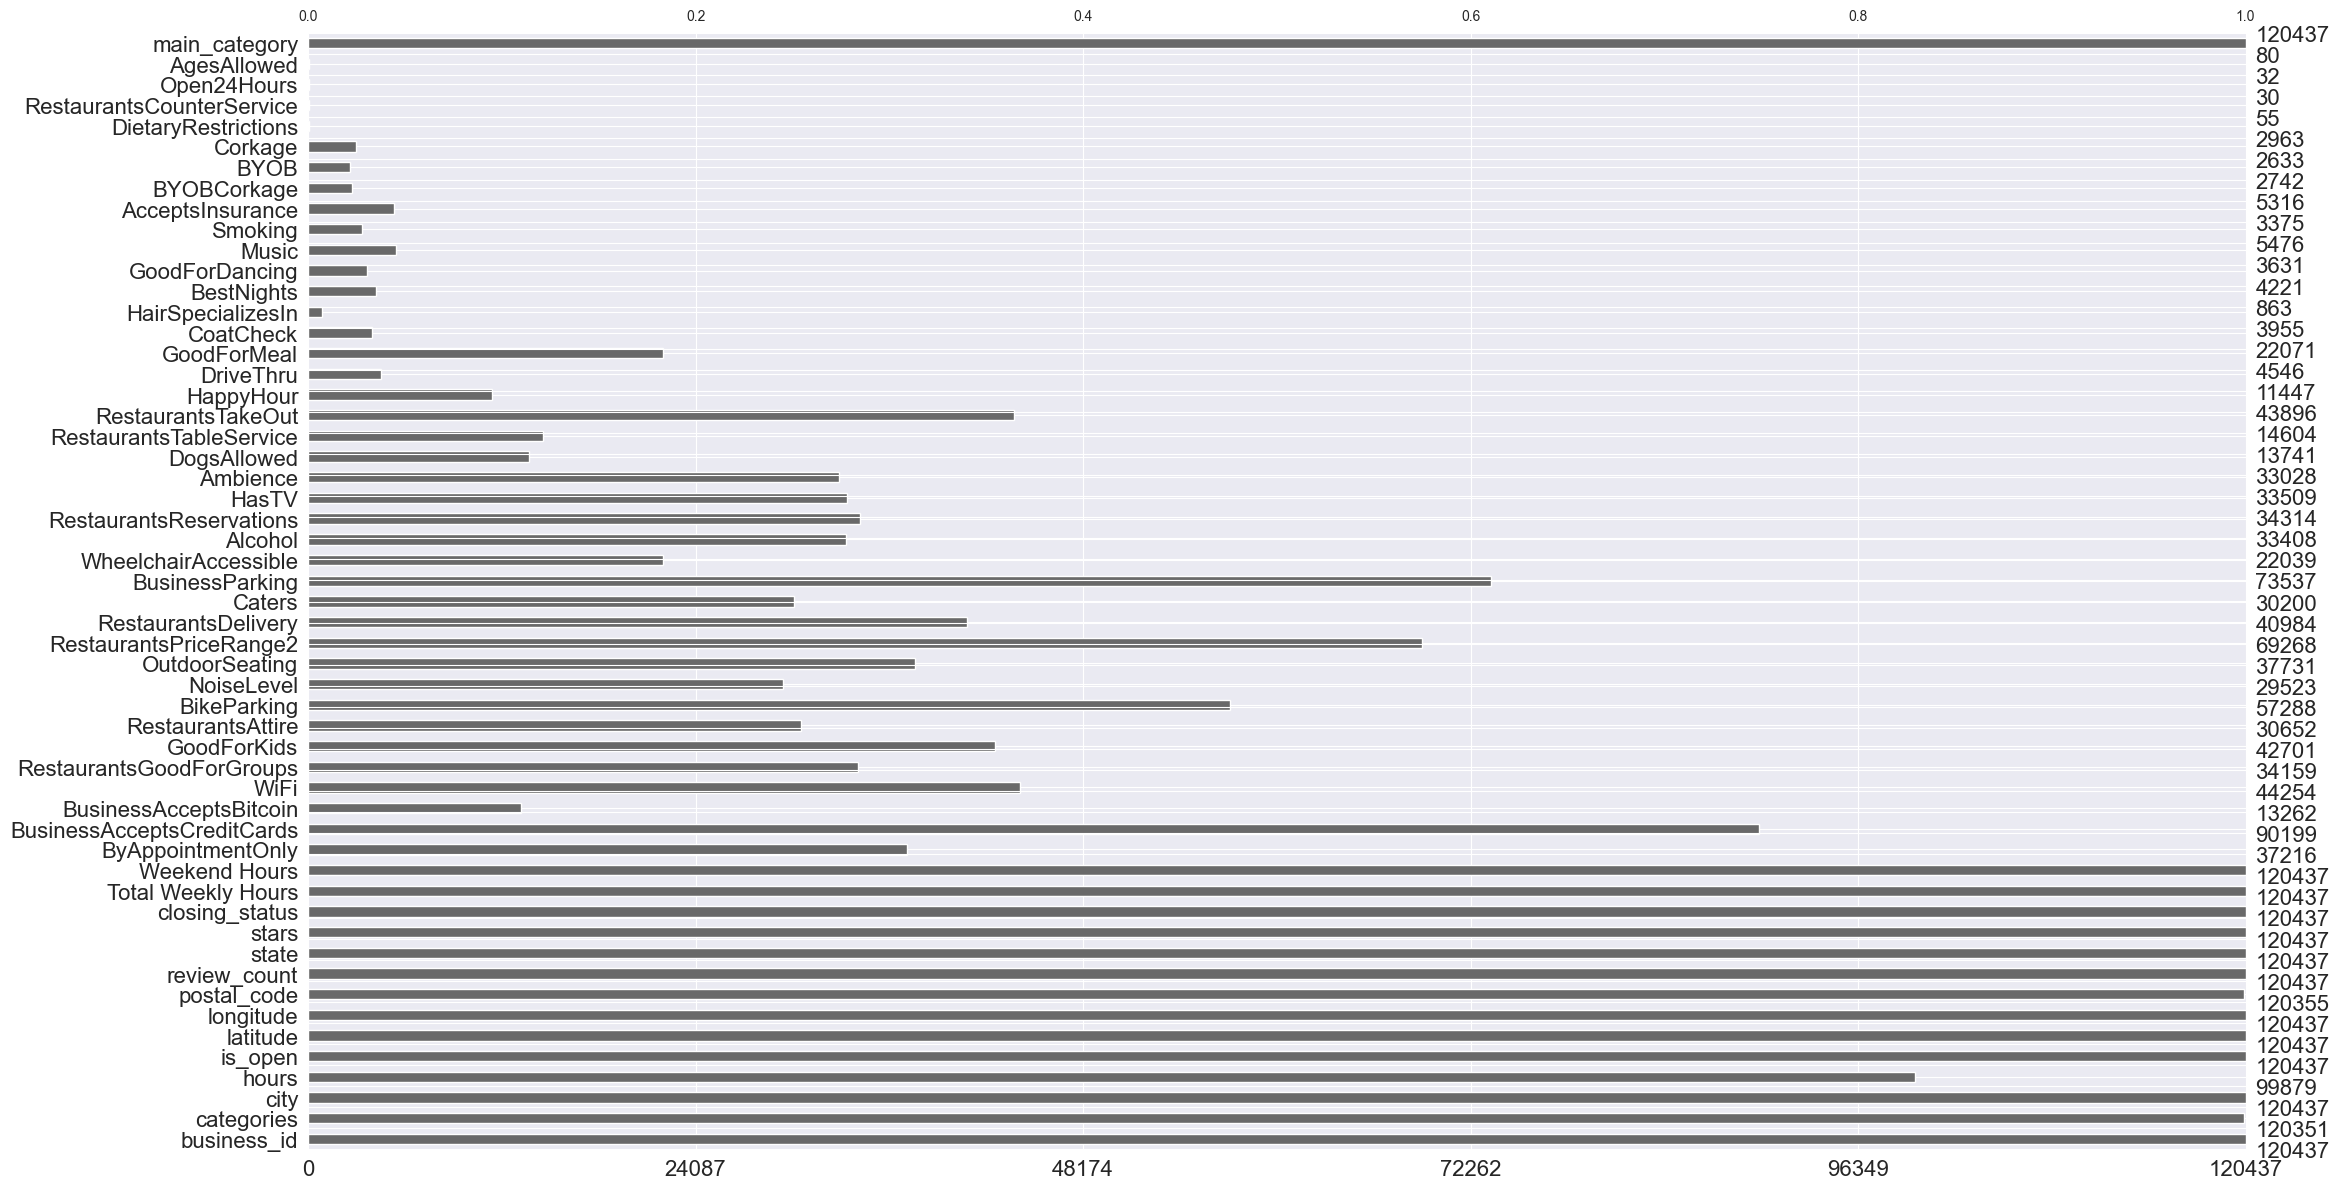

In [17]:
# Plot amount of missingness
msno.bar(df_2)

## **4. Exploratory Data**

#### **4.1. Overall Visualizations**

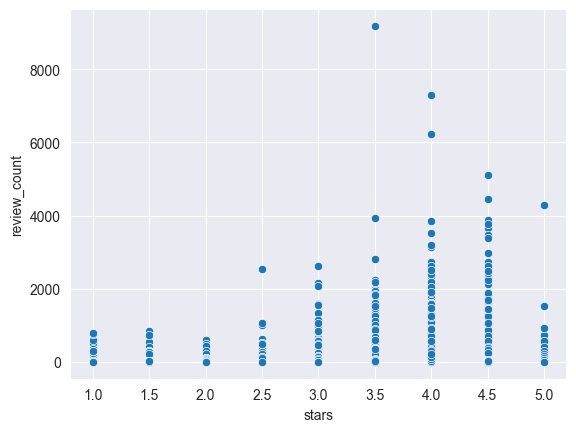

In [30]:
# Relationship between average star ratings and review counts
sns.scatterplot(df_2, x="stars", y="review_count")

plt.show()

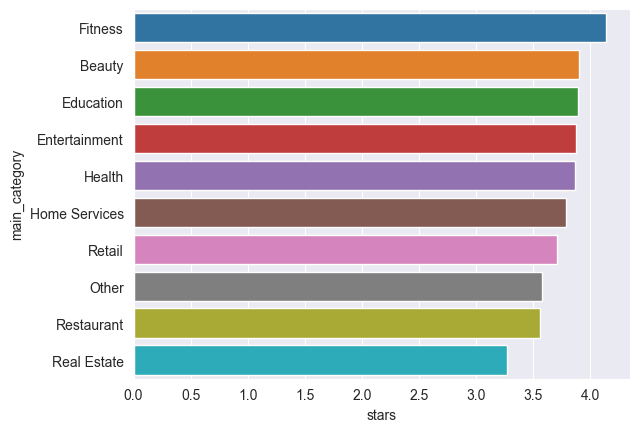

In [20]:
# Average star ratings by Main Categories
main_category_ratings = df_2.groupby('main_category')[['stars']].mean().reset_index().sort_values(by='stars', ascending=False)

# The visualization
sns.barplot(x="stars", y="main_category", data=main_category_ratings)

plt.show()

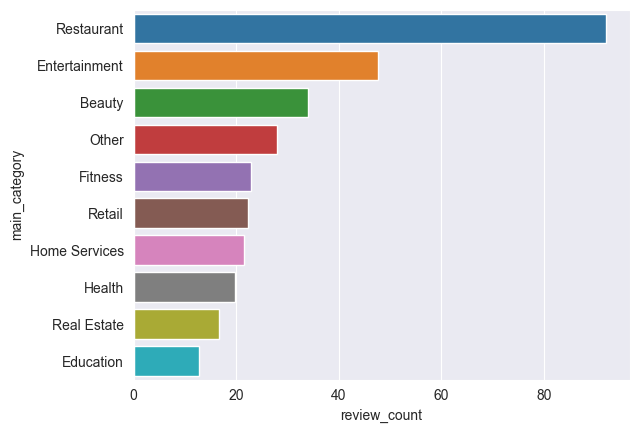

In [21]:
# Total review counts by Main Categories
main_category_ratings = df_2.groupby('main_category')[['review_count']].mean().reset_index().sort_values(by='review_count', ascending=False)

# The visualization
sns.barplot(x="review_count", y="main_category", data=main_category_ratings)

plt.show()

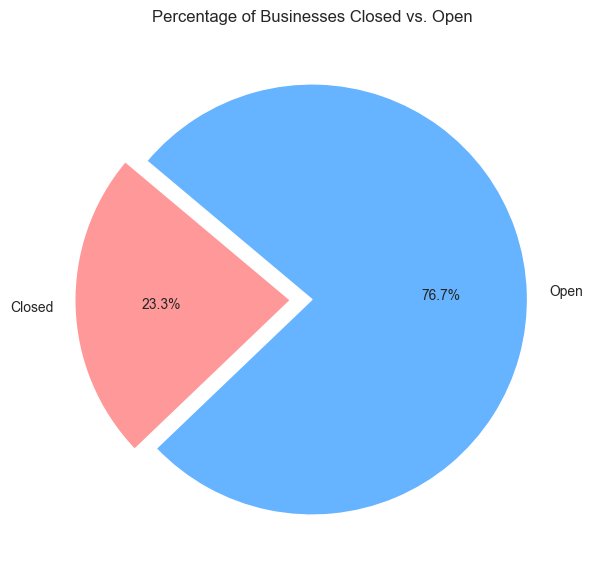

In [24]:
# Calculate the percentage
open_count = df_2['is_open'].value_counts(normalize=True) * 100
closed_percentage = open_count[0]
open_percentage = open_count[1]

# Data for visualization
labels = ['Closed', 'Open']
sizes = [closed_percentage, open_percentage]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the 'Closed' slice

# Plotting the pie chart
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Businesses Closed vs. Open')
plt.show()

#### **4.2. Separated Main Categories**

##### 4.2.1. Restaurants

In [8]:
df_2.loc[(df_2['main_category'] == 'Restaurant') & (df_2['RestaurantsDelivery'] != 'None')].groupby('RestaurantsDelivery')[['stars']].mean().reset_index().sort_values(by='stars', ascending=False)

,RestaurantsDelivery,stars
0,False,3.605253
1,True,3.449979


## **5. Model Development**

In order to dive deep into our analysis and provide Yelp with strong insights on their business. We decided to focus on three main categories, **Restaurants**, **Fitness**, and **Entertainment**. Isolating these categories is very important in the development of our models and also provides more insights on which features in each of these businesses will help them predict the average rating. These features have different impacts depending on the type of business.

In [17]:
df_2.main_category.unique()

array(['Home Services', 'Restaurant', 'Health', 'Real Estate', 'Beauty',
       'Other', 'Retail', 'Fitness', 'Entertainment', 'Education'],
      dtype=object)

### **5.1. Restaurant**

The restaurant industry is one of the most important business ...

#### 5.1.1. Filter to only Restaurant & Analyze Missing Values

In [9]:
# Filter the data to only the Restaurant businesses
df_restaurant = df_2[df_2['main_category'] == 'Restaurant']

In [20]:
# Shows the rows and columns
df_restaurant.shape

(48368, 54)

<Axes: >

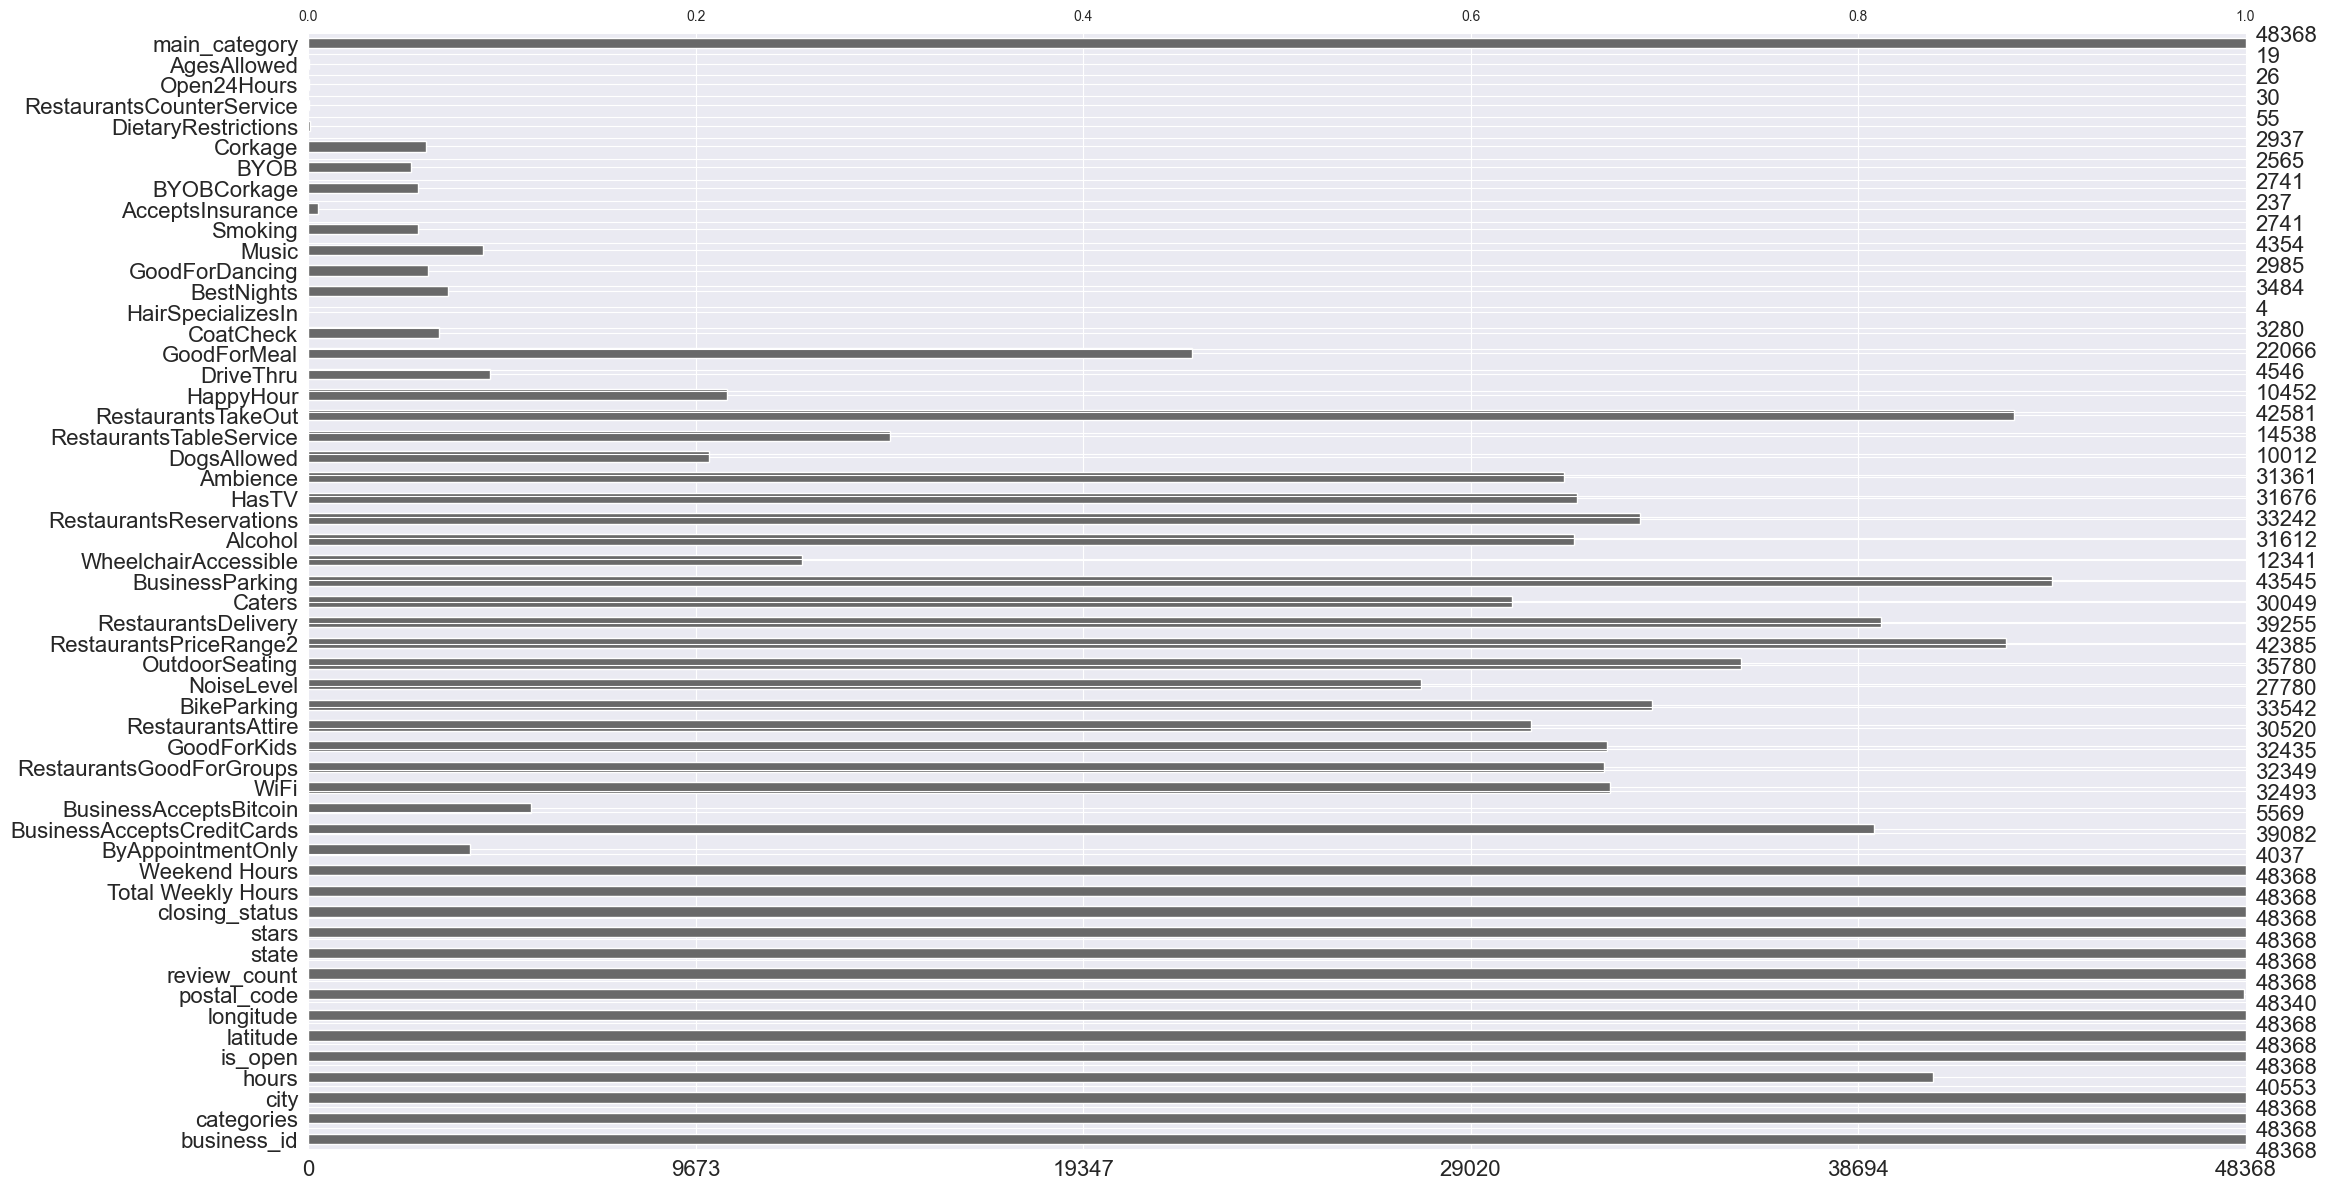

In [12]:
# Visualize the missing values in each column
msno.bar(df_restaurant)

#### 5.1.2. Select relevant columns


In [13]:
# shows all the columns
df_restaurant.columns

Index(['business_id', 'categories', 'city', 'hours', 'is_open', 'latitude',
       'longitude', 'postal_code', 'review_count', 'state', 'stars',
       'closing_status', 'Total Weekly Hours', 'Weekend Hours',
       'ByAppointmentOnly', 'BusinessAcceptsCreditCards',
       'BusinessAcceptsBitcoin', 'WiFi', 'RestaurantsGoodForGroups',
       'GoodForKids', 'RestaurantsAttire', 'BikeParking', 'NoiseLevel',
       'OutdoorSeating', 'RestaurantsPriceRange2', 'RestaurantsDelivery',
       'Caters', 'BusinessParking', 'WheelchairAccessible', 'Alcohol',
       'RestaurantsReservations', 'HasTV', 'Ambience', 'DogsAllowed',
       'RestaurantsTableService', 'RestaurantsTakeOut', 'HappyHour',
       'DriveThru', 'GoodForMeal', 'CoatCheck', 'HairSpecializesIn',
       'BestNights', 'GoodForDancing', 'Music', 'Smoking', 'AcceptsInsurance',
       'BYOBCorkage', 'BYOB', 'Corkage', 'DietaryRestrictions',
       'RestaurantsCounterService', 'Open24Hours', 'AgesAllowed',
       'main_category'],
     

In [10]:
# Stores the selected columns
restaurant_columns = ['is_open', 'review_count', 'stars', 'Weekend Hours', 'BusinessAcceptsCreditCards', 'WiFi', 'RestaurantsGoodForGroups', 'GoodForKids', 'OutdoorSeating', 'NoiseLevel', 'RestaurantsDelivery', 'RestaurantsReservations', 'RestaurantsTakeOut']

In [11]:
df_restaurant = df_restaurant[restaurant_columns]

In [41]:
df_restaurant.head()

,is_open,review_count,stars,Weekend Hours,BusinessAcceptsCreditCards,WiFi,RestaurantsGoodForGroups,GoodForKids,OutdoorSeating,NoiseLevel,RestaurantsDelivery,RestaurantsReservations,RestaurantsTakeOut
1,1,790,4.0,True,True,u'free',True,True,True,'loud',True,False,True
6,1,14,3.0,True,NaN,NaN,NaN,NaN,NaN,u'average',NaN,NaN,NaN
8,1,16,4.5,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,72,3.0,False,True,'no',True,False,True,u'loud',None,False,True
12,1,118,4.5,True,True,'no',True,True,False,u'average',False,False,True


#### 5.1.3. Data Preparation

In [12]:
# Cleans the WiFi column by replacing similar values with one that represent them
df_restaurant['WiFi'] = df_restaurant['WiFi'].replace("u'free'", "free").replace("'free'", "free").replace("u'no'", "no").replace("'no'", "no").replace("u'paid'", "paid").replace("'paid'", "paid").replace('None', np.nan)

In [44]:
# Shows the unique values in the WiFi column
df_restaurant.WiFi.unique()

array(['free', nan, 'no', 'paid'], dtype=object)

In [13]:
# Cleans the Noise Level column by replacing similar values with one that represent them
df_restaurant['NoiseLevel'] = df_restaurant['NoiseLevel'].replace("'loud'", "loud").replace("u'loud'", "loud").replace("u'average'", "average").replace("'average'", "average").replace("u'quiet'", "quiet").replace("'quiet'", "quiet").replace("u'very_loud'", "very_loud").replace("'very_loud'", "very_loud").replace('None', np.nan)

In [46]:
# Shows the unique values in the Noise Level column
df_restaurant.NoiseLevel.unique()

array(['loud', 'average', nan, 'quiet', 'very_loud'], dtype=object)

In [47]:
# Shows column information (Number of rows and columns, Column names, Number of Non-Null, and data types)
df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48368 entries, 1 to 120436
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_open                     48368 non-null  int64  
 1   review_count                48368 non-null  int64  
 2   stars                       48368 non-null  float64
 3   Weekend Hours               48368 non-null  bool   
 4   BusinessAcceptsCreditCards  39082 non-null  object 
 5   WiFi                        32465 non-null  object 
 6   RestaurantsGoodForGroups    32349 non-null  object 
 7   GoodForKids                 32435 non-null  object 
 8   OutdoorSeating              35780 non-null  object 
 9   NoiseLevel                  27767 non-null  object 
 10  RestaurantsDelivery         39255 non-null  object 
 11  RestaurantsReservations     33242 non-null  object 
 12  RestaurantsTakeOut          42581 non-null  object 
dtypes: bool(1), float64(1), int64(2), o

**Replace the 'None' & Drop missing values**

In [14]:
# Replaces 'None' values with NaN, True with 1 and False with 0
for col in df_restaurant.columns:
    df_restaurant[col] = df_restaurant[col].replace('None', np.nan).replace(True, 1).replace(False, 0).replace('True', 1).replace('False', 0)

In [50]:
# Checks for the data type if correct
df_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48368 entries, 1 to 120436
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   is_open                     48368 non-null  int64  
 1   review_count                48368 non-null  int64  
 2   stars                       48368 non-null  float64
 3   Weekend Hours               48368 non-null  int64  
 4   BusinessAcceptsCreditCards  39076 non-null  float64
 5   WiFi                        32465 non-null  object 
 6   RestaurantsGoodForGroups    32341 non-null  float64
 7   GoodForKids                 32424 non-null  float64
 8   OutdoorSeating              33993 non-null  float64
 9   NoiseLevel                  27767 non-null  object 
 10  RestaurantsDelivery         37504 non-null  float64
 11  RestaurantsReservations     33105 non-null  float64
 12  RestaurantsTakeOut          41726 non-null  float64
dtypes: float64(8), int64(3), object(2)


In [51]:
# Shows the shape of data (rows and columns) before dropping the missing values
df_restaurant.shape

(48368, 13)

In [15]:
# Drops all the missing values from the DataFrame
df_restaurant_cleaned = df_restaurant.dropna()

In [25]:
# Shows the shape of data (rows and columns) after dropping the missing values
df_restaurant_cleaned.shape

(18081, 13)

#### 5.1.4. Model development: OLS (Ordinary Least Squares)

In [16]:
# Stores the necessary features for model development
features_restaurant = df_restaurant_cleaned.drop(columns=['stars'])

In [17]:
# Transform the categorical features to numerical
X_restaurant = pd.get_dummies(features_restaurant, columns=['WiFi', 'NoiseLevel'], drop_first=True)

In [18]:
# Stores the target column
y_restaurant = df_restaurant_cleaned['stars']

In [19]:
# Change the data type of boolean columns to integers
for col in ['WiFi_no', 'WiFi_paid', 'NoiseLevel_loud', 'NoiseLevel_quiet', 'NoiseLevel_very_loud']:
    X_restaurant[col] = X_restaurant[col].astype('int')

In [20]:
# Splits the data into training and testing
X_restaurant_train, X_restaurant_test, y_restaurant_train, y_restaurant_test = train_test_split(X_restaurant, y_restaurant, test_size=0.2, random_state=42)

In [21]:
# Add a constant to the model (intercept)
X_sm_restaurant = sm.add_constant(X_restaurant_train)

In [22]:
# Fit the OLS model
model_restaurant = sm.OLS(y_restaurant_train, X_sm_restaurant).fit()

In [23]:
# Print the summary of the regression
print(model_restaurant.summary())

                            OLS Regression Results                            
Dep. Variable:                  stars   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     165.9
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:22:05   Log-Likelihood:                -14085.
No. Observations:               14464   AIC:                         2.820e+04
Df Residuals:                   14448   BIC:                         2.832e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

#### 5.1.5. Model Evaluation

In [34]:
# Add a constant to the model (intercept)
X_sm_restaurant_test = sm.add_constant(X_restaurant_test)

In [35]:
# Predicted values on the training set
y_train_pred = model_restaurant.predict(X_sm_restaurant_test)

In [37]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_restaurant_test, y_train_pred)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.4216572812680197


In [39]:
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 0.6493514312512291


In [51]:
r2 = r2_score(y_restaurant_test, y_train_pred)

In [52]:
print(r2)

0.1485089636192175


#### 5.1.6. Model development: Random Forest

In [41]:
# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_restaurant_train, y_restaurant_train)

# Predict on the test set
y_rf_pred = rf_model.predict(X_restaurant_test)

# Evaluation metrics
mse_rf = mean_squared_error(y_restaurant_test, y_rf_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_restaurant_test, y_rf_pred)


In [48]:
# Print Random Forest Regressor feature importances
print("Random Forest Regressor Feature Importances:")
for idx, importance in enumerate(rf_model.feature_importances_):
    print(f"{X_restaurant_train.columns[idx]}: {importance}")


Random Forest Regressor Feature Importances:
is_open: 0.04410996189530791
review_count: 0.5173858438212583
Weekend Hours: 0.04748067073109079
BusinessAcceptsCreditCards: 0.012582169471129502
RestaurantsGoodForGroups: 0.042003398574596965
GoodForKids: 0.03655611399021111
OutdoorSeating: 0.043959046468091484
RestaurantsDelivery: 0.05391710283088285
RestaurantsReservations: 0.042448777806465436
RestaurantsTakeOut: 0.016956939792240177
WiFi_no: 0.06042120909375057
WiFi_paid: 0.005515673923227483
NoiseLevel_loud: 0.023644433448482754
NoiseLevel_quiet: 0.034434352413947523
NoiseLevel_very_loud: 0.018584305739317204


In [45]:
# Print evaluation metrics
print(f'Random Forest Regressor - MSE: {mse_rf}')
print(f'Random Forest Regressor - RMSE: {rmse_rf}')
print(f'Random Forest Regressor - R² Score: {r2_rf}')

Random Forest Regressor - MSE: 0.49995188205919505
Random Forest Regressor - RMSE: 0.7070727558456732
Random Forest Regressor - R² Score: -0.00959847038551298


#### 5.1.6. Model development: Gradient Boosting Regressor

In [46]:
# Initialize the model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gb_model.fit(X_restaurant_train, y_restaurant_train)

# Predict on the test set
y_gb_pred = gb_model.predict(X_restaurant_test)

# Evaluation metrics
mse_gb = mean_squared_error(y_restaurant_test, y_gb_pred)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_restaurant_test, y_gb_pred)




In [49]:
# Print Gradient Boosting Regressor feature importances
print("Gradient Boosting Regressor Feature Importances:")
for idx, importance in enumerate(gb_model.feature_importances_):
    print(f"{X_restaurant_train.columns[idx]}: {importance}")


Gradient Boosting Regressor Feature Importances:
is_open: 0.06235980022634518
review_count: 0.2988555898762945
Weekend Hours: 0.15284126784419927
BusinessAcceptsCreditCards: 0.037783945475191164
RestaurantsGoodForGroups: 0.02711043668705496
GoodForKids: 0.022761980311554412
OutdoorSeating: 0.06444112195634849
RestaurantsDelivery: 0.18576123067525696
RestaurantsReservations: 0.015247894157165183
RestaurantsTakeOut: 0.0036550372221194885
WiFi_no: 0.009518336411972183
WiFi_paid: 0.003849155793054684
NoiseLevel_loud: 0.03219417366321622
NoiseLevel_quiet: 0.0365838030467824
NoiseLevel_very_loud: 0.047036226653445104


In [47]:
# Print evaluation metrics
print(f'Random Forest Regressor - MSE: {mse_rf}')
print(f'Gradient Boosting Regressor - RMSE: {rmse_gb}')
print(f'Gradient Boosting Regressor - R² Score: {r2_gb}')

Random Forest Regressor - MSE: 0.49995188205919505
Gradient Boosting Regressor - RMSE: 0.6225235739246464
Gradient Boosting Regressor - R² Score: 0.21741398899983788
